In [1]:
# import libraries
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' # for tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [2]:
# Set the random seed for replicated results
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Load data from CSV file
data = pd.read_csv('dataset.csv', header=None)

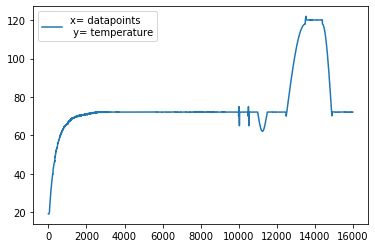

In [4]:
#plot the data 
plt.plot(data,label = 'x= datapoints \n y= temperature')
plt.legend()
plt.show()

In [5]:
raw_train_data = data.iloc[:10000]
raw_test_data = data.iloc[10000:]
raw_train_data.shape, raw_test_data.shape #returns (rows, columns)

((10000, 1), (6000, 1))

In [6]:
### scale the data
scaler = StandardScaler()
scaler = scaler.fit(np.array(raw_train_data).reshape(-1,1))
train_data = scaler.transform(np.array(raw_train_data).reshape(-1,1))
test_data = scaler.transform(np.array(raw_test_data).reshape(-1,1))


In [7]:
### create sequence
TIME_STEPS = 400

def create_sequences(dataset, time_steps=TIME_STEPS):
    """
    Creates sequences from the input data with the given time steps
    """
    X_out = []
    y_out = []
    for i in range(len(dataset) - time_steps):
        X_out.append(dataset[i:i+time_steps])
        y_out.append(dataset[i+time_steps])
    return np.array(X_out), np.array(y_out)

In [8]:
# Assuming you have a single column univariate data called 'data'
# We can create sequences with a specified number of time steps using the create_sequences function

X_train, y_train = create_sequences(train_data, TIME_STEPS)
X_test, y_test = create_sequences(test_data, TIME_STEPS)

# output format (number of sequence, length of batches, number of features)
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (9600, 400, 1)
Testing input shape:  (5600, 400, 1)


In [9]:
# Define LSTM autoencoder model
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(TIME_STEPS, 1)))
##model.add(Dropout(rate=0.2))
model.add(RepeatVector(TIME_STEPS))
model.add(LSTM(64, activation='tanh', return_sequences=True))
##model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='mse')

In [10]:
# Train the model and save the history
history = model.fit(X_train, X_train, epochs=16, batch_size=300, validation_data=(X_test, X_test), verbose=1,)


Epoch 1/16
32/32 [==============================] - 21s 670ms/step - loss: 0.3583 - val_loss: 9.1585
Epoch 2/16
32/32 [==============================] - 21s 646ms/step - loss: 0.1799 - val_loss: 8.0189
Epoch 3/16
32/32 [==============================] - 21s 646ms/step - loss: 0.0666 - val_loss: 8.2526
Epoch 4/16
32/32 [==============================] - 21s 644ms/step - loss: 0.0554 - val_loss: 8.2167
Epoch 5/16
32/32 [==============================] - 21s 642ms/step - loss: 0.0511 - val_loss: 8.1942
Epoch 6/16
32/32 [==============================] - 21s 641ms/step - loss: 0.0484 - val_loss: 8.1218
Epoch 7/16
32/32 [==============================] - 21s 644ms/step - loss: 0.0462 - val_loss: 8.0304
Epoch 8/16
32/32 [==============================] - 21s 646ms/step - loss: 0.0440 - val_loss: 7.9651
Epoch 9/16
32/32 [==============================] - 21s 644ms/step - loss: 0.0398 - val_loss: 7.9407
Epoch 10/16
32/32 [==============================] - 21s 646ms/step - loss: 0.0385 - val_lo

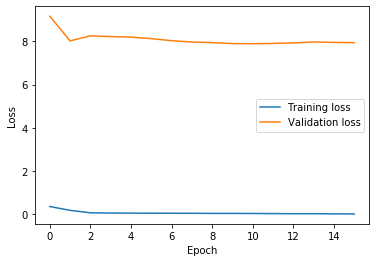

In [11]:
### Plot Training - Validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [12]:
# Make predictions on the train dataset
X_train_pred = model.predict(X_train, verbose=1)


300/300 [==============================] - 15s 51ms/step


In [13]:
# Calculate MAE loss on the train dataset
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
# Flatten the train_mae_loss array
##train_mae_loss = train_mae_loss.flatten()


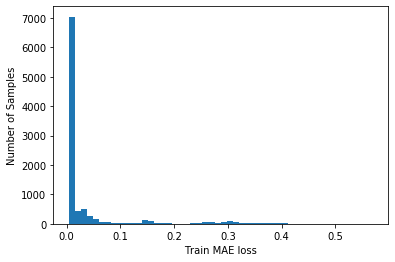

In [14]:
# Visualize MAE loss on the train dataset
plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')
plt.show()

In [15]:
# Make predictions on the test dataset
X_test_pred = model.predict(X_test, verbose=1)


175/175 [==============================] - 9s 51ms/step


In [16]:
# Calculate MAE loss on the test dataset
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)


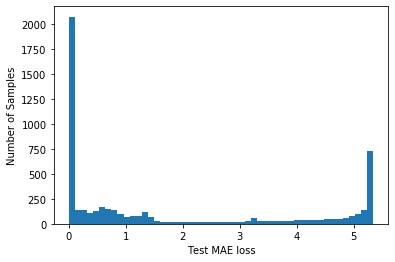

In [17]:
# Visualize MAE loss on the test dataset
plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of Samples')
plt.show()

In [18]:
# Set the threshold for anomaly detection
# threshold = 0.5
threshold = np.mean(train_mae_loss) + 3 * np.std(train_mae_loss)

In [19]:
threshold

0.28808486574833164

In [31]:
# convert raw_test_data.to_numpy() array to fit in the table
sensor_data = raw_test_data.to_numpy()

# Create anomaly dataframe
anomaly_df = pd.DataFrame(columns=['Timesteps', 'Sensor_data', 'Test_loss', 'Threshold', 'Anomaly'])

# Add data to the anomaly dataframe
anomaly_df['Timesteps'] = range(TIME_STEPS, len(raw_test_data))
anomaly_df['Sensor_data'] = sensor_data[TIME_STEPS:]
anomaly_df['Test_loss'] = test_mae_loss

# Add the threshold column to the anomaly dataframe
anomaly_df['Threshold'] = threshold

# Find the anomalous data points
anomaly_df['Anomaly'] = anomaly_df['Test_loss'] > anomaly_df['Threshold']

# Print the anomaly dataframe
print(anomaly_df)

      Timesteps  Sensor_data  Test_loss  Threshold  Anomaly
0           400    72.121361   0.059553   0.288085    False
1           401    72.121368   0.060189   0.288085    False
2           402    72.121399   0.060670   0.288085    False
3           403    72.121429   0.060947   0.288085    False
4           404    72.118942   0.061027   0.288085    False
...         ...          ...        ...        ...      ...
5595       5995    72.121811   0.009047   0.288085    False
5596       5996    72.121788   0.009104   0.288085    False
5597       5997    72.121773   0.009152   0.288085    False
5598       5998    72.121758   0.009194   0.288085    False
5599       5999    72.121750   0.009230   0.288085    False

[5600 rows x 5 columns]


In [21]:
anomaly_df.head(3333)

,Timesteps,Sensor_data,Test_loss,Threshold,Anomaly
0,400,72.121361,0.059553,0.288085,False
1,401,72.121368,0.060189,0.288085,False
2,402,72.121399,0.060670,0.288085,False
3,403,72.121429,0.060947,0.288085,False
4,404,72.118942,0.061027,0.288085,False
...,...,...,...,...,...
3328,3728,120.128662,5.187388,0.288085,True
3329,3729,120.126694,5.188647,0.288085,True
3330,3730,120.138878,5.189900,0.288085,True
3331,3731,120.164886,5.191156,0.288085,True


In [22]:
anomaly_df['Test_loss']

0       0.059553
1       0.060189
2       0.060670
3       0.060947
4       0.061027
          ...   
5595    0.009047
5596    0.009104
5597    0.009152
5598    0.009194
5599    0.009230
Name: Test_loss, Length: 5600, dtype: float64

In [23]:
anomaly_df['Sensor_data']

0       72.121361
1       72.121368
2       72.121399
3       72.121429
4       72.118942
          ...    
5595    72.121811
5596    72.121788
5597    72.121773
5598    72.121758
5599    72.121750
Name: Sensor_data, Length: 5600, dtype: float64

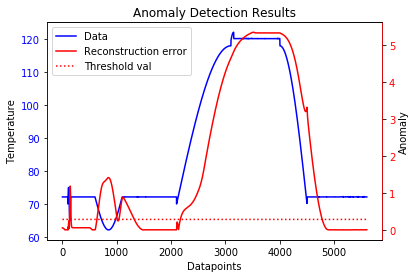

In [36]:
# Plot the anomaly dataframe and test dataset
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

color1 = 'blue'
color2 = 'red'

line1 = ax1.plot(anomaly_df.index, anomaly_df['Sensor_data'], color=color1, label = 'Data')
line2 = ax2.plot(anomaly_df.index, anomaly_df['Test_loss'], color=color2, label = 'Reconstruction error')
line3 = ax2.plot(anomaly_df.index, anomaly_df['Threshold'], color=color2, linestyle = 'dotted', label = 'Threshold val')

#ax2.set_ylim([-0.1, 1.1])
plt.title('Anomaly Detection Results')
#plt.xlabel('Test data')
ax1.set_xlabel('Datapoints')
ax1.set_ylabel('Temperature')
ax2.set_ylabel('Anomaly')

ax2.spines['left'].set_color(color1)
ax2.spines['right'].set_color(color2)
ax1.tick_params(axis = 'y', labelcolor = color1)
ax2.tick_params(axis = 'y', labelcolor = color2)

lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc = "upper left")

plt.show()


In [25]:
anomaly_df.head(3333)

,Timesteps,Sensor_data,Test_loss,Threshold,Anomaly
0,400,72.121361,0.059553,0.288085,False
1,401,72.121368,0.060189,0.288085,False
2,402,72.121399,0.060670,0.288085,False
3,403,72.121429,0.060947,0.288085,False
4,404,72.118942,0.061027,0.288085,False
...,...,...,...,...,...
3328,3728,120.128662,5.187388,0.288085,True
3329,3729,120.126694,5.188647,0.288085,True
3330,3730,120.138878,5.189900,0.288085,True
3331,3731,120.164886,5.191156,0.288085,True


In [35]:
# Initialize variables for anomaly detection
window_size = TIME_STEPS
num_windows = int(len(raw_test_data) / window_size)
consecutive_anomalies = 0

# Check each window of test data for anomalies
for i in range(num_windows):
    start_index = i * window_size
    end_index = start_index + window_size
    
    # Get the anomaly status for this window
    window_anomalies = anomaly_df['anomaly'][start_index:end_index].values
    
    # Check if any anomalies were detected in this window
    if window_anomalies.sum() == 0:
        print(f"Window {i+1}: Normal Operation")
        consecutive_anomalies = 0
    else:
        print(f"Window {i+1}: Anomaly Detected")
        consecutive_anomalies += 1
        
        # Check if three consecutive windows had anomalies
        if consecutive_anomalies >= 3:
            print("Fault Detected!")
            consecutive_anomalies = 3

KeyError: 'anomaly'